Objective: predict the 5 powerball numbers (not the 6th #, which is the powerball-- i chose this b/c it comes from another pool of balls)

Dataset:The dataset contains past winning powerball numbers in the order of date they were drawn + in the order they were drawn on that date (e.g. not numerical order). i think i might explore transformers w/ this later b/c self attention mechanism might be useful if balls are all in order they were drawn

Problem Type: Supervised, [?] Task

Performance Measure: [?]

Guide: Following this video https://www.youtube.com/watch?v=IuVY3hcukXY 

Files:
main.ipynb
exploratory_analysis.ipynb

**note to self: later convert this jupyter notebook into two .py files : functions & main script

IMPORT MODULES

In [2]:
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from matplotlib import pyplot

DOWNLAOD DATA + CREATE PANDAS DATAFRAME

In [3]:
#FUNCTIONS
def url_to_df(url,csv_path):
    #DOWNLOAD DATA
    #this will pull data from tx powerball website
    #it pulls the numbers in the order drawn 
    req=requests.get(url)
    url_content=req.content
    csv_file=open(csv_path,'wb')
    csv_file.write(url_content)
    csv_file.close()

    #CREATE PANDAS DATAFRAME
    raw_df=pd.read_csv(csv_path, header=None)
    return raw_df

def clean_df(raw_df):
    #combine day,month,year columns into one column
    date_col=raw_df[1].astype(str) + "-"+ raw_df[2].astype(str) +"-"+ raw_df[3].astype(str)
    #drop powerplay, day,month,year,columns & "Powerball" string column
    raw_df=raw_df.drop(raw_df.columns[10],axis=1) 
    raw_df=raw_df.drop(raw_df.columns[0:4],axis=1) 

    #insert date as first column
    #we dont need the date for training but i just wanna make sure data is in correct order
    raw_df.insert(loc=0,column='Date Drawn',value=date_col)
    #rename columns
    raw_df.columns=['Date Drawn','First','Second','Third','Fourth','Fifth','Powerball']

    #save this version dataframe as csv for exploratory analysis later (for fun)
    raw_df.to_csv('explore_powerball.csv')

    #ok now let's remove 'date drawn' & 'powerball' b/c wont train w these
    raw_df=raw_df.drop(['Date Drawn','Powerball'],axis=1)
    
    return raw_df

#SCRIPT
url="https://www.texaslottery.com/export/sites/lottery/Games/Powerball/Winning_Numbers/powerball.csv"
csv_path='raw_powerball.csv'

raw_df=url_to_df(url,csv_path)
pb_df=clean_df(raw_df)
    

SPLIT INTO TRAIN / VALIDATION/ TEST DATAFRAMES

p.s. set shuffle=False since we want the lottery #s to stay in the order they were drawn 

p.s.s part of training can be set to validation  be fitting the model  -- but doing this now so that I can control whether I normalize the training/validation set or not (separately)
Train-Set: Used for training.
Validation-Set / Dev-Set: Used for tuning hyper-parameters.
Test-Set: Used for unbiased estimation.


In [4]:
#SCRIPT 
train_df, test_df = train_test_split(pb_df, test_size=0.1, shuffle=False)
train_df, valid_df=train_test_split(train_df, test_size=0.2, shuffle=False)

NORMALIZE TRAIN / VALIDATION/ TEST DATAFRAMES

p.s. I'm not sure if it's the right choice to normalize this data- I've written the code so I can try w/ and w/out normalization

p.s. "Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

When normalizing the test set, one should apply the normalization parameters previously obtained from the training set as-is. Do not recalculate them on the test set, because they would be inconsistent with the model and this would produce wrong predictions."

https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split


In [5]:
#FUNCTIONS

def norm_train_df(train_df,normalize):
    #fit to / transform train data
    if normalize:
        scaler=StandardScaler().fit(train_df.values)
        train_norm=scaler.transform(train_df.values)
        train_norm_df=pd.DataFrame(data=train_norm,index=train_df.index)
    else:
        scaler=False
    return train_norm_df, scaler
    
def norm_other_df(other_df,scaler):
    #now transform test data using norm. params from train data
    #other df= validation & test dfs
    if scaler:
        other_norm=scaler.transform(other_df.values)
        other_norm_df=pd.DataFrame(data=other_norm,index=other_df.index)
    else
        other_norm_df=other_df

    return other_norm_df
#SCRIPT

normalize=True #yes or no
train_norm_df,scaler=norm_train_df(train_df,normalize)
valid_norm_df=norm_other_df(valid_df,scaler)
test_norm_df=norm_other_df(test_df,scaler)

    


CREATE NUMPY ARRAYS OF TRAIN / VALIDATION / TEST FEATURES & LABELS (AKA INPUT FORMAT OF DEEP LEARNING MODEL)

p.s. this is why I pre-allocate the data arrays & then load images into them
https://hjweide.github.io/efficient-image-loading

In [6]:
#FUNCTION

def DL_format(norm_df,window_len):
    #format for keras lstm = (# rows, window size, # balls)
    num_rows=len(norm_df)
    num_features=len(norm_df.columns)
    

    #create train dataset (features + labels separately)
    features=np.empty([num_rows-window_len,window_len,num_features],dtype=float)
    labels=np.empty([num_rows-window_len,num_features],dtype=float)
    for i in range(0,num_rows-window_len):
        features[i]=norm_df.iloc[i:i+window_len,0:num_features]
        labels[i]=norm_df.iloc[i+window_len: i+window_len+1, 0:num_features]
        
    #verify shapes of train/label:
    print("features shape= ",str(features.shape),"\nlabel shape= " ,str(labels.shape))

    #verify content of train/label:
    #sample=1
    #print("features sample= \n",str(features[sample]),"\nlabel sample=",str(labels[sample]))
    
    return features,labels


#SCRIPT
window_len=10 #num of past games we'll consider for prediction
print('TRAIN DATA')
train_features, train_labels=DL_format(train_norm_df,window_len)
print('VALIDATION DATA')
valid_features, valid_labels=DL_format(valid_norm_df,window_len)
print('TEST DATA')
test_features, test_labels=DL_format(test_norm_df,window_len)


TRAIN DATA
features shape=  (993, 10, 5) 
label shape=  (993, 5)
VALIDATION DATA
features shape=  (241, 10, 5) 
label shape=  (241, 5)
TEST DATA
features shape=  (130, 10, 5) 
label shape=  (130, 5)


IMPORT MODULES FOR MODEL TRAINING

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


CREATE MODEL

p.s. here's some tips for deciding # of hidden layers & nodes 

https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm




In [8]:
#FUNCTION

def create_model(train_features):
    window_len=train_features.shape[1]
    num_features=train_features.shape[2]
    #create model
    model=Sequential()
    model.add(LSTM(56,activation='relu',
                input_shape=(window_len,num_features),
                return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(56,activation='relu',
                return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(num_features))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

    print(model.summary())
    
    return model
#SCRIPT

model=create_model(train_features)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 56)            13888     
                                                                 
 dropout (Dropout)           (None, 10, 56)            0         
                                                                 
 lstm_1 (LSTM)               (None, 56)                25312     
                                                                 
 dropout_1 (Dropout)         (None, 56)                0         
                                                                 
 dense (Dense)               (None, 5)                 285       
                                                                 
Total params: 39,485
Trainable params: 39,485
Non-trainable params: 0
_________________________________________________________________
None


TRAIN MODEL

p.s. tips on splitting data train/validation/test
https://www.v7labs.com/blog/train-validation-test-set

p.s.s for hyperparameter tuning (including window length), explore application of gridsearchcv 
https://www.geeksforgeeks.org/hyperparameter-tuning-using-gridsearchcv-and-kerasclassifier/

p.s.s.s you could also try pruning the network after training (refer to "the lottery ticket hypothesis" google/youtube)

In [9]:
#SCRIPT
#set hyperparameters
batch_size_num=15
epochs_num=10
val_split=0.2

trained_model=model.fit(train_features,train_labels,batch_size=batch_size_num,epochs=epochs_num,validation_data=(valid_features,valid_labels))


Epoch 1/10


2022-11-04 22:55:06.048397: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 1s 6ms/step - loss: 1.0022 - accuracy: 0.1944 - val_loss: 1.1647 - val_accuracy: 0.1535
Epoch 2/10
67/67 [==============================] - 0s 5ms/step - loss: 0.9987 - accuracy: 0.2044 - val_loss: 1.1534 - val_accuracy: 0.1992
Epoch 3/10
67/67 [==============================] - 0s 4ms/step - loss: 0.9969 - accuracy: 0.2216 - val_loss: 1.1680 - val_accuracy: 0.1037
Epoch 4/10
67/67 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.2306 - val_loss: 1.1501 - val_accuracy: 0.1120
Epoch 5/10
67/67 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.2296 - val_loss: 1.1544 - val_accuracy: 0.1286
Epoch 6/10
67/67 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.2356 - val_loss: 1.1523 - val_accuracy: 0.1245
Epoch 7/10
67/67 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.2538 - val_loss: 1.1555 - val_accuracy: 0.1203
Epoch 8/10
67/67 [=============

DIAGNOSE OVERFITTING/UNDERFITTING OF MODEL

https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/


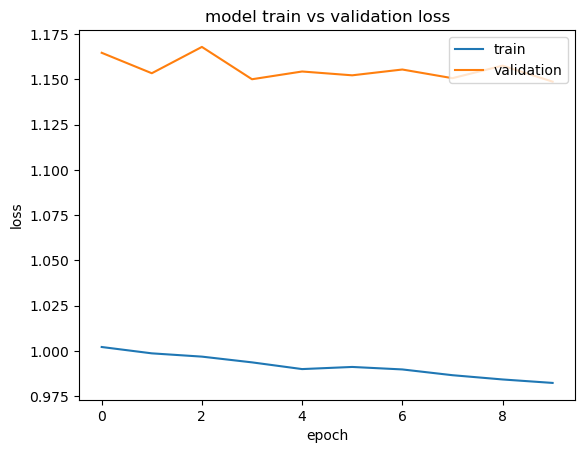

In [10]:
#FUNCTION
def plot_train_val(trained_model):
    pyplot.plot(trained_model.history['loss'])
    pyplot.plot(trained_model.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
#SCRIPT
plot_train_val(trained_model)    

EVALUATE TEST SET

In [13]:
def eval_test(test_features,test_labels):
    scores=model.evaluate(test_features,test_labels)
    LSTM_accuracy = scores[1]*100
    print('Test accuracy: ', scores[1]*100)
    
eval_test(test_features,test_labels)

def print_pred_vs_actual(test_features,test_lables,normalize,scaler):
    test_predictions=model.predict(test_features)

    if normalize=='yes':
        test_predictions_=scaler.inverse_transform(test_predictions).astype(int)
        test_labels_=scaler.inverse_transform(test_labels).astype(int)
    else:
        test_predictions_=test_predictions
        test_labels_=test_labels

    for i in range(len(test_predictions)):
        print('\nactual lotto #s:    ',test_labels_[i])
        print('predicted lotto #s: ',test_predictions_[i])
    

5/5 [==============================] - 0s 2ms/step - loss: 1.1348 - accuracy: 0.1846
Test accuracy:  18.46153885126114
5/5 [==============================] - 0s 1ms/step

actual lotto #s:     [25  6 14 33 46]
predicted lotto #s:  [33 33 34 34 32]

actual lotto #s:     [21 20 65 36 60]
predicted lotto #s:  [32 32 33 34 31]

actual lotto #s:     [17 21 14 27 18]
predicted lotto #s:  [32 32 33 33 31]

actual lotto #s:     [21 22 30 12 33]
predicted lotto #s:  [32 31 33 33 30]

actual lotto #s:     [ 3 59 37 51 18]
predicted lotto #s:  [32 31 33 33 30]

actual lotto #s:     [46 65 24 35  9]
predicted lotto #s:  [32 30 32 33 30]

actual lotto #s:     [11 43 61 15 55]
predicted lotto #s:  [31 29 32 32 30]

actual lotto #s:     [67 14  8 33 36]
predicted lotto #s:  [30 29 31 29 28]

actual lotto #s:     [11 53 47 30 29]
predicted lotto #s:  [30 30 31 30 29]

actual lotto #s:     [69 38 49  4 11]
predicted lotto #s:  [30 31 32 30 30]

actual lotto #s:     [54  2 15 65 38]
predicted lotto #s:  

PREDICT UPCOMING LOTTO #S 


In [ ]:
#already normalized & formatted test data before
#prediction=model.predict(recent_window)
#print(scaler.inverse_transform(prediction).astype(int)[0])

9/9 [==============================] - 0s 2ms/step
[32 29  9 22 26]
